In [1]:
import os
import time
import copy
import pickle
import urllib
import datetime
from tqdm import tqdm_notebook, tqdm
from collections import Counter

from astropy.io import fits
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
from torchvision.models.resnet import BasicBlock
from torch.optim import lr_scheduler

import pretrainedmodels

from sklearn.metrics import f1_score
from skimage.transform import resize, rescale

import warnings
# import cv2

plt.ion()
warnings.filterwarnings("ignore")

In [4]:
# First experiments wa with Adam and below settings
num_epochs = 50
num_classes = 7
batch_size = 10
learning_rate = 0.001

# model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)

url_pkl = 'https://raw.githubusercontent.com/iknyazeva/FitsProcessing/master/sunspot_1996_2017.pkl'
dataset_folder = 'HMIdataset/fragments/'
with urllib.request.urlopen(url_pkl) as pkl:
    sunspots = pickle.load(pkl)
sunspots.tail(5)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
distributions_classes = Counter([class_[0] for class_ in sunspots['class']])
distributions_classes

current_time = str(datetime.datetime.now().timestamp())
train_log_dir = 'logs/tensorboard/train/' + current_time
test_log_dir = 'logs/tensorboard/test/' + current_time
# train_summary_writer = summary.create_file_writer(train_log_dir)
# test_summary_writer = summary.create_file_writer(test_log_dir)

# torch.cuda.current_device()

[1121, 3254, 3302, 3952, 7101, 7227, 7794]
[0.03321383 0.09641196 0.09783414 0.11709283 0.21039377 0.21412699
 0.23092649]


<module 'sklearn.utils.class_weight' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\sklearn\\utils\\class_weight.py'>

### Dataset Class

In [ ]:
class SunRegionDataset(data_utils.Dataset):
    def __init__(self, path_to_df_pkl, path_to_fits_folder, height, width,
                 only_first_class=False, transformations=None, logarithm=True):
        """
        Args:
            path_to_df_pkl (string): path or url to pkl file represents pandas dataframe with labels
            path_to_image_folder (string): path to folder with fits
            height (int): image height
            width (int): image width
            only_first_class (bool): create dataset with only one letter represents first layer of Mctosh classes
            transformation: pytorch transforms for transforms and tensor conversion
        """
        if path_to_df_pkl.startswith('http'):
            with urllib.request.urlopen(path_to_df_pkl) as pkl:
                self.sunspots = pickle.load(pkl)
        else:
            self.sunspots = pickle.load(path_to_df_pkl)
        self.classes = np.asarray(self.sunspots.iloc[:, 2].unique())
        self.height = height
        self.width = width
        self.folder_path, self.dirs, self.files = next(os.walk(path_to_fits_folder))
        self.len = len(self.files)
        self.ind = list(range(self.len))
        self.transformations = transformations
        self.alb_transorms = alb.Compose([
                                        alb.RandomRotate90(p=0.1),
                                        alb.Rotate(75, p=0.1),
                                        alb.Resize(224, 224, p=0.1),
                                        alb.RandomCrop(200, 200, p=0.1),
                                        alb.HorizontalFlip(),
                                        # alb.Transpose(),
                                        alb.VerticalFlip(),
                                        alb.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
                                        ], p=0.7)
        self.to_tensor = torch.from_numpy
        self.only_first_class = only_first_class
        self.height = height
        self.width = width
        self.logarithm = logarithm
        self.first_classes = set([class_[0] for class_ in self.sunspots['class'].unique()])
        self.second_classes = set([class_[1] for class_ in self.sunspots['class'].unique()])
        self.third_classes = set([class_[2] for class_ in self.sunspots['class'].unique()])
        self.max = self.find_max_dataset()

    def __getitem__(self, index):
        file_path = os.path.join(self.folder_path, self.files[index])
        with fits.open(file_path) as fits_file:
            data = fits_file[0].data

        if self.transformations is None:
            if self.logarithm:
                data = self.log_normalize(data)
            data = self.normalize_data(data)
            # data = resize(data, (self.height, self.width), anti_aliasing=True)
            data = self.aug()(image=data)['image']
            data = self.to_tensor(data).float()  # uncomment for float
        else:
            data = self.transformations(data)

        mc_class = self.get_attr_region(self.files[index], self.sunspots, self.only_first_class)

        for ind, letter in enumerate(sorted(self.first_classes)):
            if letter == mc_class:
                num_class = ind

#         return (data, num_class, mc_class)
        return {"image": data, "label": num_class, "letter_label": mc_class}

    def __len__(self):
        return self.len

    def show_region(self, index):
        '''Plot region by index from dataset
        index: int, index of sample from dataset
        '''
        date, region = self.files[index].split('.')[1:3]
        file_path = os.path.join(self.folder_path, self.files[index])
        with fits.open(file_path) as fits_file:
            data = fits_file[0].data
        class_, size, location, number_ss = self.get_attr_region(self.files[index],
                                                                 self.sunspots,
                                                                 only_first_class=False,
                                                                 only_class=False)
        ax = plt.axes()
        ax.set_title(
            'Region {} on date {} with class {} on location {} with size {} and number_of_ss {}'
            .format(region, date, class_, location, size, number_ss))
        ax.imshow(data)
        # ax.annotate((24,12))

    def get_attr_region(self, filename, df, only_first_class=False, only_class=True):
        date, region = filename.split('.')[1:3]
        reg_attr = df.loc[date[:-7], int(region[2:])]
        if only_first_class:
            return reg_attr['class'][0]
        elif (not only_class) and (only_first_class):
            class_, \
                size, \
                location, \
                number_ss = reg_attr[['class', 'size', 'location', 'number_of_ss']]
            return class_[0], size, location, number_ss
        elif (not only_class) and (not only_first_class):
            return reg_attr[['class', 'size', 'location', 'number_of_ss']]
        else:
            return reg_attr['class']

    def log_normalize(self, data):
        return np.sign(data) * np.log1p(np.abs(data))

    def normalize_data(self, data):
        return data / self.max

    def find_max_dataset(self):
        m = []
        for file in self.files:
            with fits.open(self.folder_path + file) as ff:
                m.append(np.nanmax(np.abs(ff[0].data)))
        return np.max(m)
    
    def aug(self):
        return self.alb_transorms

    def split_dataset(self, val_size=None, test_size=None):
        '''Spliting dataset in optional test, train, val datasets
        test_size (optional): float from 0 to 1.
        val_size (optional): float from 0 to 1.
        shuffle (optional): bool, for shuffled smaples in datasets

        Returns datasets in order (train, valid, test)

        '''
        len_all = self.len
        test_split_size = int(np.floor(test_size * len_all)) if test_size else 0
        val_split_size = int(np.floor(val_size * len_all)) if val_size else 0
        train_split_size = len_all - test_split_size - val_split_size

        return data_utils.random_split(self, [train_split_size, val_split_size, test_split_size])

### Net Class

In [505]:
def conv3x3(in_planes, out_planes, stride=1, groups=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, groups=groups, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class SunBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(SunBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class SunNet(nn.Module):

    def __init__(self, block, layers, num_classes=7, zero_init_residual=False):
        super(SunNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

### Train Func

In [575]:
def train_model(model, data_loaders, datasets_sizes, criterion, optimizer, scheduler, num_epochs=25, tensorboard=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    losses = {'train':[], 'val':[]}
    f1_weight = {'train':[], 'val':[]}
    f1_micro = {'train':[], 'val':[]}
    accuracies = {'train':[], 'val':[]}
    
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        scheduler.step()
        lr = scheduler.get_lr()[0]
        
        ps = {'train': [],'val':[]}
        ls = {'train': [],'val': []}
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels, classes in tqdm(data_loaders[phase]):
                inputs = inputs #.to(device)
                labels = labels #.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                ps[phase].extend(preds.cpu().numpy().tolist()) 
                ls[phase].extend(labels.cpu().numpy().tolist())

            epoch_loss = running_loss / datasets_sizes[phase]
            epoch_acc = running_corrects.double() / datasets_sizes[phase]
            f1_weight[phase].append(f1_score(ls[phase], ps[phase], average='weighted'))
            f1_micro[phase].append(f1_score(ls[phase], ps[phase], average='micro'))
            accuracies[phase].append(epoch_acc)
            losses[phase].append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f} F1 (weighted): {:4f}  and F1 (micro): {:4f}'.format(
                phase, epoch_loss, epoch_acc, f1_weight[phase][-1], f1_micro[phase][-1]))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if tensorboard and phase=='train':
                with train_summary_writer.as_default():
                    summary.scalar('loss', loss.item(), step=epoch)
                    summary.scalar('accuracy', epoch_acc, step=epoch)
                    summary.scalar('F1_Weighted', f1_weight[phase][-1], step=epoch)
                    summary.scalar('accuracy', f1_micro[phase][-1], step=epoch)
            if tensorboard and phase=='val':
                with test_summary_writer.as_default():
                    summary.scalar('loss', loss.item(), step=epoch)
                    summary.scalar('accuracy', epoch_acc, step=epoch)
                    summary.scalar('F1_Weighted', f1_weight[phase][-1], step=epoch)
                    summary.scalar('accuracy', f1_micro[phase][-1], step=epoch)                    
                    

        callbacks = {'losses_phases': losses, 'accuracies': accuracies, 
                     'f1': {'weighted':f1_weight, 'micro':f1_micro}
                    }
        
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': epoch_loss,
                    'accuracy': epoch_acc,
                    'callbacks': callbacks
                   }, 'checkpoint_model.pt')
        print()
    

    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}\nBest val F1 (weighted): {:4f}  and F1 (micro): {:4f}'.format(best_acc, f1_weight['val'], f1_micro['val']))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, callbacks

In [54]:
# cifar = torchvision.datasets.CIFAR10('cifar', train=True, transform=transforms.ToTensor())
# cifar_loader = data_utils.DataLoader(cifar, 3)

regions_dataset = SunRegionDataset(path_to_df_pkl=url_pkl,  path_to_fits_folder='MDIdataset/fragments/', height=224, width=224, only_first_class=True, logarithm=True)
train_dataset, val_dataset, test_dataset = regions_dataset.split_dataset(0.1, 0.1)

train_loader = data_utils.DataLoader(train_dataset, batch_size=10, shuffle=False, num_workers=0)
val_loader = data_utils.DataLoader(val_dataset, batch_size=10, shuffle=True, num_workers=0)
test_loader = data_utils.DataLoader(test_dataset, batch_size=10, shuffle=True, num_workers=0)
regions_loader = data_utils.DataLoader(regions_dataset, 10, num_workers=0)
# x = iter(train_loader[0]).next()
data_loaders = {'train':train_loader, 'val': val_loader}
datasets_sizes = {'train':len(train_dataset), 'val': len(val_dataset)}
# x = iter(regions_loader).next()
# x[0]



# sunnet = SunNet(SunBlock, [3,4,6,3])

# loss = nn.CrossEntropyLoss()

# optimizer_sun = optim.Adam(sunnet.parameters(), lr=0.00146, betas=(0.9, 0.999), weight_decay=0.0005) # TODO: play with hyperparameters

# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_sun, step_size=10, gamma=0.1)

# normal_lr_scheduler = lr_scheduler.StepLR(optimizer_sun, step_size=10, gamma=0.8)

# cycle_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_sun, T_max=num_epochs, eta_min=0.000001)

# sunnet = train_model(sunnet, data_loaders, datasets_sizes, loss, optimizer_sun, exp_lr_scheduler, num_epochs=50)


# model(transforms.ToTensor()(cifar[:10][0]).resize(10,3,32,32))

In [55]:
regions_dataset[10]

{'image': tensor([[ 0.0008,  0.0007,  0.0009,  ...,  0.0004,  0.0005,  0.0005],
         [ 0.0007,  0.0005,  0.0007,  ..., -0.0007, -0.0008, -0.0008],
         [ 0.0007,  0.0009, -0.0008,  ...,  0.0009,  0.0004, -0.0007],
         ...,
         [ 0.0008, -0.0009, -0.0006,  ..., -0.0007,  0.0005, -0.0006],
         [ 0.0007, -0.0007, -0.0005,  ...,  0.0004,  0.0005, -0.0007],
         [ 0.0009,  0.0007, -0.0002,  ..., -0.0009, -0.0002, -0.0008]]),
 'label': 3,
 'letter_label': 'D'}

In [582]:
# outputs = sunnet(x[0])
print(outputs)
torch.max(outputs, 1)
len(val_loader)

tensor([[ 0.4528, -0.1940, -0.0797, -0.7034, -0.2084, -0.1775,  0.0536],
        [ 0.7549, -0.3385, -0.4236, -1.1187,  0.0051, -0.2978,  0.2588],
        [ 0.3077, -0.2040, -0.1783, -0.6386, -0.1580, -0.1978,  0.0607],
        [ 0.3761, -0.1947, -0.0980, -0.6559, -0.1981, -0.1030,  0.0292],
        [ 0.3609, -0.1150, -0.3129, -0.8036, -0.0543, -0.2087,  0.0293],
        [ 0.3881, -0.2365, -0.3863, -0.8483, -0.0368, -0.2360,  0.1457],
        [ 0.4206, -0.1121, -0.1736, -0.7261, -0.1240, -0.2022, -0.0156],
        [ 1.7945, -1.2375, -0.8469, -2.1831,  0.7635, -0.7405,  0.2315],
        [ 1.4358, -0.7727, -0.4365, -1.8009,  0.2740, -0.7384,  0.2392],
        [ 1.0297, -0.5459, -0.4272, -1.3580,  0.0383, -0.5198, -0.0661]],
       grad_fn=<AddmmBackward>)


6

In [981]:
example_file = 'HMI.2010-07-23_000000.AR11089.fits'
sunspots.loc['2010-07-23']

,,number_of_ss,size,class,location,magn_class
date,region,,,,,
2010-07-23,11089,29,240,DSI,S23E33,B


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


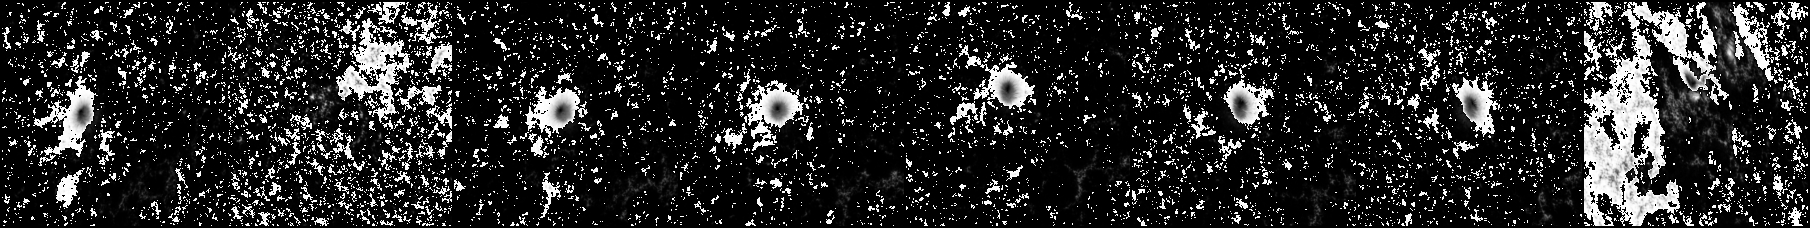

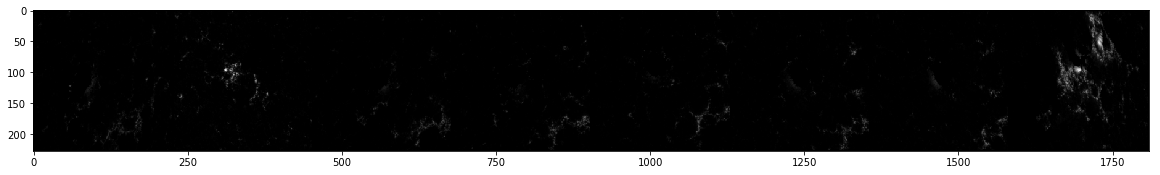

In [492]:
region_dataset = RegionDataset(url_pkl, dataset_folder, 224, 224, True)
loader = data_utils.DataLoader(region_dataset, 10)
regions = iter(loader).next()

def imshow(img):
#     npimg = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)), cmap='Accent')
#     plt.imshow(npimg)

plt.figure(figsize=(20,20))
imshow(torchvision.utils.make_grid(regions[0][:8]))
transforms.ToPILImage()(torchvision.utils.make_grid(regions[0][:8]))

In [170]:
# with open('cifar-10-batches-py/data_batch_1', 'rb') as file:
#     cifar = pickle.load(file, encoding='bytes')
print(set(cifar[b'labels']))
list(range(len(classes)))

classes

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


{'A', 'B', 'C', 'D', 'E', 'F', 'H'}

In [425]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                        stride=stride, padding=1, bias=False)

m = nn.Conv2d(3, 16, 3, stride=1, padding=1)
# m(torch.rand(1, 10, 10))
# torch.rand(1, 3, 2)
# m(region_dataset[2][0].resize(1, 1, 224,224)).shape
# m(transforms.ToTensor()(cifar[2][0]))
# region_dataset[0][:10]
# conv3x3(3, 16)(transforms.ToTensor()(cifar[2][0]).resize(1,3,32,32))

torch.Size([1, 16, 32, 32])

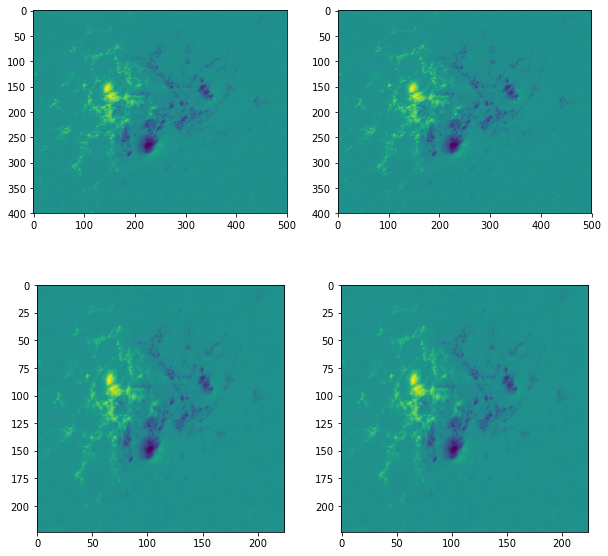

In [654]:
def normalize_data(data):
        return data/np.max(np.abs(data))

pretreined_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    

transform = transforms.Compose([transforms.Lambda(normalize_data), transforms.ToTensor()])


tensor = transform(data)
# tensor[0, one[ind], two[ind]]
# transforms.Resize(200)(normdata)
# normdata2.resize((200,200), refcheck=False)
# print(one, two)
# PIL.Image.fromarray((normdata2))
# pilim = PIL.Image.open('normdata.png')
# plt.imshow(resize(normdata, (224, 224)))
# pilim.resize((224, 224))
# plt.imshow(rescale(data, 0.5))
plt.figure(figsize=(10,10))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)
ax1.imshow(data)
ax2.imshow(normdata)
ax3.imshow(resize(data, (224,224)))
ax4.imshow(resize(normdata, (224,224)))

In [552]:
# torch.utils.data.DataLoader
print(normdata.min(), normdata.max())
print(resize(normdata, (224,224)).min(), resize(normdata, (224,224)).max())
resize(normdata, (224,224), anti_aliasing=True)

-1.0 0.9931109009860867
-0.9831066000173591 0.9694918802507826


NameError: name 'size' is not defined

In [26]:
1e-2

0.01

In [389]:
# cifar = torchvision.datasets.CIFAR10('cifar')
transforms.ToTensor()(cifar[1][0]).shape

torch.Size([3, 32, 32])

In [181]:
# ??models.ResNet
# ??models.resnet18
# resnet_classes10 = models.ResNet(num_classes=10)
# resnet_classes10

# ??models.resnet.BasicBlock
# ??data_utils.DataLoader

26


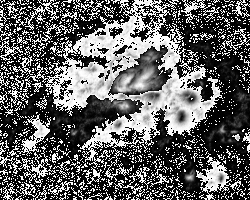

In [10]:
path, dirs, files = next(os.walk("MDIdataset/fragments/"))
print(len(files))
files[6]
with fits.open(path+files[2]) as fts:
    data = fts[0].data
(transforms.ToPILImage()(transforms.ToTensor()(data/np.abs(data.max())).float()))

pp


Text(100, 100, 'lololo')

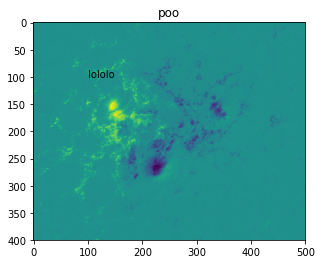

In [887]:
# ax = plt.plot(10)
ax = plt.axes()
ax.set_title('poo')
ax.imshow(normdata)
ax.annotate('lololo', (100,100))

# Написать про багу в пайторч!

In [155]:
lin_model = nn.Linear(10, 2)
lin_optim = optim.Adam(lin_model.parameters(), lr=0.00146, betas=(0.9, 0.999), weight_decay=0.0005) # TODO: play with hyperparameters
sched = lr_scheduler.CosineAnnealingLR(lin_optim, T_max=5, eta_min=0.001, last_epoch=2)

for i in tqdm_notebook(range(5)):
    for i in range(10):
        sched.step()
        print(sched.get_lr())
       


KeyError: "param 'initial_lr' is not specified in param_groups[0] when resuming an optimizer"

In [184]:
m = []
f = []
for file in os.listdir('MDIdataset/fragments/'):
    date, region = file.split('.')[1:3]
    with fits.open('MDIdataset/fragments/'+file) as fits_file:
        if np.nanmax(np.abs(fits_file[0].data)) > 
        m.append(np.nanmax(np.abs(fits_file[0].data)))


np.max(m)

3977.35

torch.Size([1, 200, 250])
torch.Size([1, 200, 250])


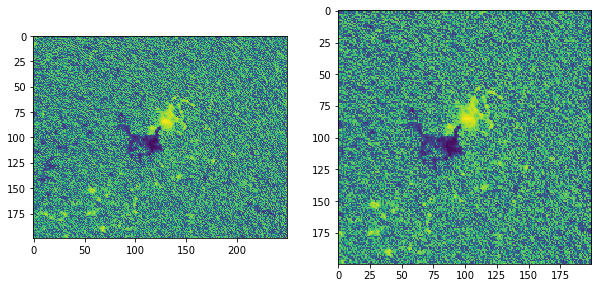

In [12]:
import albumentations as alb
file = np.random.choice(os.listdir('MDIdataset/fragments/')[18:20])
with fits.open('MDIdataset/fragments/'+file) as fits_file:
        data = fits_file[0].data
        data = np.sign(data)*np.log1p(np.abs(data))
        data = data/np.nanmax(np.abs(data))
#         data = np.rot90(data)*1
#         data = np.flip(data, np.random.randint(0,1))*1
#         data = np.rot90(data)*1
#         data = np.reshape(data, (1, 224, 224))

#         tr = transforms.Compose([transforms.ToTensor()])
#         data = torch.from_numpy(data).float()
#         data = tr(data)
#         torch.from_numpy(data).float()


# data.strides
# f, (a1, a2, a3, a4) = plt.subplots(1,4, figsize=(20,20))
# a1.imshow(data)
# a2.imshow(alb.RandomRotate90(data))
def augment_flips_color(p=.5):
    return alb.Compose([
        alb.RandomRotate90(p=0.1),
        alb.Rotate(75, p=.1),
        alb.Resize(224, 224, p=0.1),
        alb.RandomCrop(200, 200, p=0.1),
        alb.HorizontalFlip(),
        alb.VerticalFlip(),
        alb.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.5)
    ], p=p)

alb_tr = alb.Compose([
        alb.RandomRotate90(p=0.1),
        alb.Rotate(75, p=.1),
        alb.Resize(224, 224, p=0.1),
        alb.RandomCrop(200, 200, p=0.1),
        alb.HorizontalFlip(),
        alb.VerticalFlip(),
        alb.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.5)
    ], p=1)


def augment_and_show(aug, image):
    aug_image = aug(image=image)['image']
    f, (a1, a2) = plt.subplots(1,2, figsize=(10,10))
    a1.imshow(image)
    a2.imshow(aug_image)
    print(transforms.ToTensor()(image).shape)
    print(torch.from_numpy(data.reshape(1, 200, -1)).shape)
    return aug_image, transforms.ToTensor()(aug_image)


aug = augment_flips_color(p=1)
aeee, ueee = augment_and_show(aug, data)

In [30]:
import torch.nn.functional as F
input = torch.tensor([[[-10,-2, 3,-4,-5,-6,-7]]], dtype=torch.float)
F.max_pool1d(input, kernel_size=3, stride=2)

tensor([[[ 3.,  3., -5.]]])

In [567]:
import cv2 #[-0.0042, -0.0017, -0.0024,  ...,  0.0002, -0.0028,  0.0034]
import albumentations.pytorch


with fits.open('MDIdataset/fragments/'+os.listdir('MDIdataset/fragments/')[18]) as fits_file:
        data = fits_file[0].data
        data = np.sign(data)*np.log1p(np.abs(data))
        data = data/np.nanmax(np.abs(data))
        

os.listdir('MDIdataset/fragments/')[18]


False

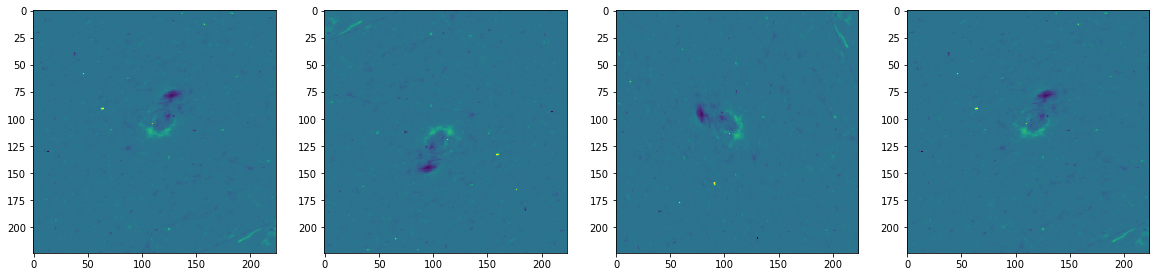

In [323]:
f, (a1, a2, a3, a4) = plt.subplots(1,4, figsize=(20,20))
a1.imshow(data);
a2.imshow(np.flip(data)*1);
a3.imshow(np.rot90(data, 1));
a4.imshow(np.rot90(data, 4)*1);
# data.shape

In [239]:
# checkpoints = torch.load('checkpoint_model_v0.1.pt')

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss', 'losses_phases', 'f1_phases'])


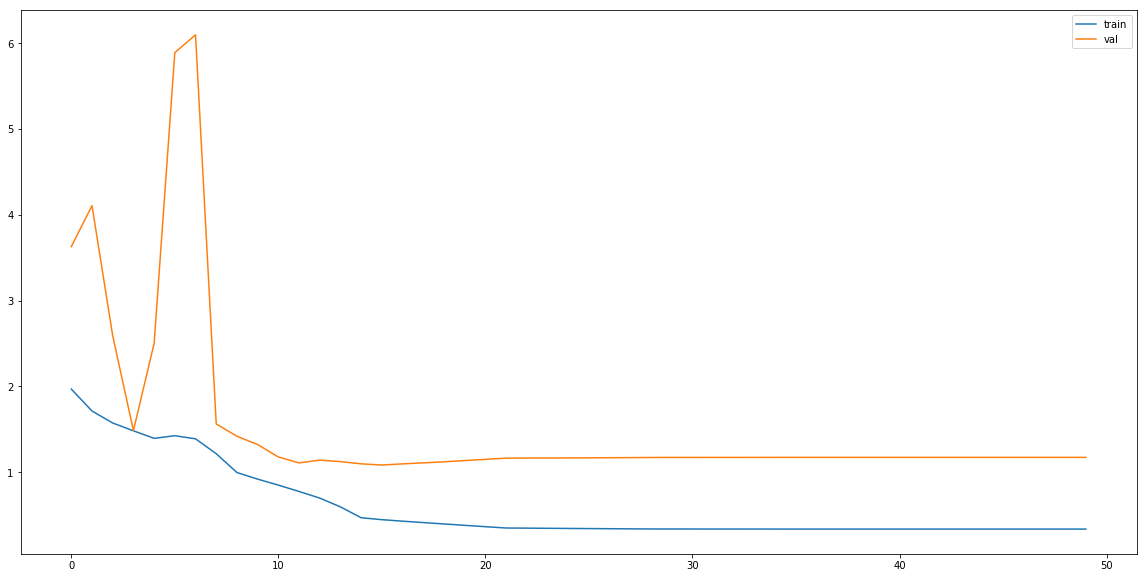

In [24]:
print(checkpoints.keys())
# checkpoints['losses_phases']

plt.figure(figsize=(20,10))
plt.plot(checkpoints['losses_phases']['train'], label='train')
plt.plot(checkpoints['losses_phases']['val'], label='val')
plt.legend()

In [28]:
# np.repeat(data.reshape(1, 200, 250), 3, axis=1).shape
# np.repeat(aeee.shape)
# ueee.repeat(3,1)
x = torch.tensor([1, 2, 3])
x.shape
x.repeat(4, 1).shape
pic = aeee.reshape(aeee.shape[0],aeee.shape[1], 1, 1).repeat(3, axis=3)
aeee.reshape(aeee.shape[0],aeee.shape[1],1, 1).repeat(3, axis=3).shape
# ueee.repeat(3,1,1).shape

# a = transforms.ToPILImage()(pic.astype('float32'))
b = transforms.ToPILImage()(ueee.float())
# pic.shape

c = Image.open('image.png')
# print(transforms.ToTensor()(c))
ueee.repeat(3,1,1).float()
# np.stack([aeee]*3, axis=-1).shape

torch.Size([3, 200, 200])

In [31]:
transforms.ToTensor()(transforms.ToPILImage()(ueee.repeat(3,1,1).float()))

tensor([[[0.1373, 0.4941, 0.6510,  ..., 0.5961, 0.5804, 0.6824],
         [0.4039, 0.4588, 0.4471,  ..., 0.5804, 0.6824, 0.4078],
         [0.5725, 0.4863, 0.5059,  ..., 0.5216, 0.6824, 0.6392],
         ...,
         [0.7020, 0.4627, 0.6000,  ..., 0.5647, 0.4627, 0.5255],
         [0.5255, 0.4000, 0.6000,  ..., 0.8235, 0.6510, 0.4392],
         [0.4353, 0.2824, 0.4000,  ..., 0.4902, 0.4902, 0.6510]],

        [[0.1373, 0.4941, 0.6510,  ..., 0.5961, 0.5804, 0.6824],
         [0.4039, 0.4588, 0.4471,  ..., 0.5804, 0.6824, 0.4078],
         [0.5725, 0.4863, 0.5059,  ..., 0.5216, 0.6824, 0.6392],
         ...,
         [0.7020, 0.4627, 0.6000,  ..., 0.5647, 0.4627, 0.5255],
         [0.5255, 0.4000, 0.6000,  ..., 0.8235, 0.6510, 0.4392],
         [0.4353, 0.2824, 0.4000,  ..., 0.4902, 0.4902, 0.6510]],

        [[0.1373, 0.4941, 0.6510,  ..., 0.5961, 0.5804, 0.6824],
         [0.4039, 0.4588, 0.4471,  ..., 0.5804, 0.6824, 0.4078],
         [0.5725, 0.4863, 0.5059,  ..., 0.5216, 0.6824, 0.

In [36]:
import pretrainedmodels as pm
for model in  pm.model_names:
    print(model, '\n', pm.pretrained_settings[model], '\n')

fbresnet152 
 {'imagenet': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/fbresnet152-2e20f6b4.pth', 'input_space': 'RGB', 'input_size': [3, 224, 224], 'input_range': [0, 1], 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'num_classes': 1000}} 

bninception 
 {'imagenet': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/bn_inception-52deb4733.pth', 'input_space': 'BGR', 'input_size': [3, 224, 224], 'input_range': [0, 255], 'mean': [104, 117, 128], 'std': [1, 1, 1], 'num_classes': 1000}} 

resnext101_32x4d 
 {'imagenet': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/resnext101_32x4d-29e315fa.pth', 'input_space': 'RGB', 'input_size': [3, 224, 224], 'input_range': [0, 1], 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'num_classes': 1000}} 

resnext101_64x4d 
 {'imagenet': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/resnext101_64x4d-e77a0586.pth', 'input_space': 'RGB', 'input_size': [3, 224, 224], 'input_range': [0, 1], 'mean': [0.485,

In [33]:
{l for l in 'abcder'}

{'a', 'b', 'c', 'd', 'e', 'r'}